In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imsize = 256  # you can change to 512 if you have a GPU with more memory

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # Resizing both images to same size
    transforms.ToTensor()
])


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving cat.jpg to cat.jpg


In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  # Add batch dimension
    return image.to(device, torch.float)

style_img = image_loader("/content/style1.jpg")      # Replace with your actual filename
content_img = image_loader("/content/cat.jpg")  # Replace with your actual filename


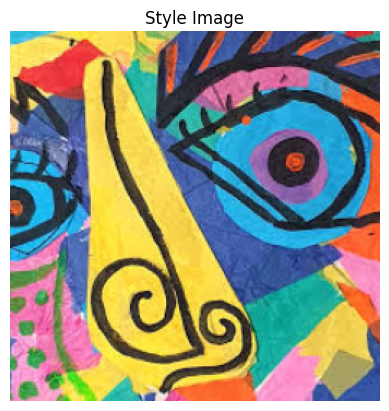

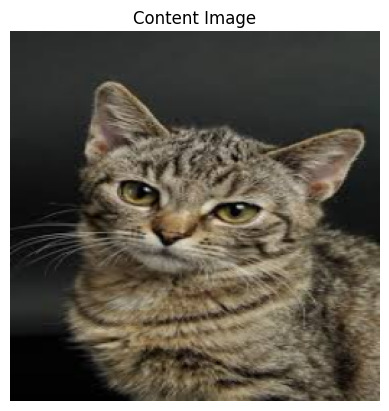

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

imshow(style_img, title="Style Image")
imshow(content_img, title="Content Image")


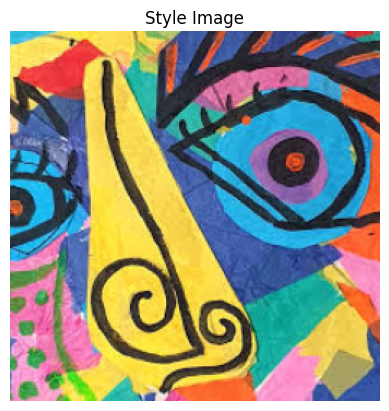

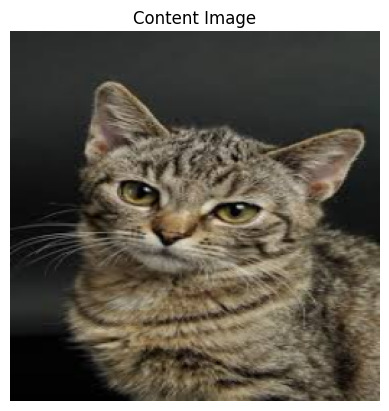

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

imshow(style_img, title="Style Image")
imshow(content_img, title="Content Image")


In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    batch_size, ch, h, w = input.size()
    features = input.view(ch, h * w)
    G = torch.mm(features, features.t())
    return G.div(ch * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x


In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std


In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.7MB/s]


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                style_img, content_img,
                                content_layers=['conv_4'],
                                style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim off the model after the last loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]

    return model, style_losses, content_losses


In [ ]:
input_img = content_img.clone()
input_img.requires_grad_(True)

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_img, content_img
)

optimizer = optim.LBFGS([input_img])


Running NST...
Step 50:
Style Loss: 0.001760, Content Loss: 45.512543
Step 100:
Style Loss: 0.000395, Content Loss: 47.194496
Step 150:
Style Loss: 0.000194, Content Loss: 48.122318
Step 200:
Style Loss: 0.000101, Content Loss: 49.153629
Step 250:
Style Loss: 0.000050, Content Loss: 49.452663
Step 300:
Style Loss: 0.000030, Content Loss: 49.233566


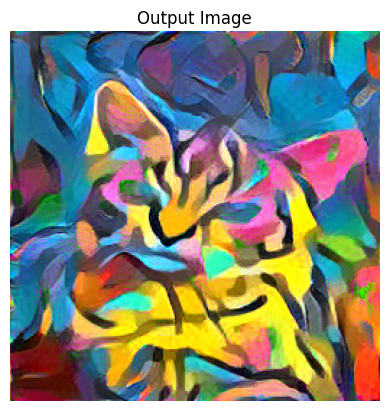

In [ ]:
num_steps = 300
style_weight = 1e6
content_weight = 1

print("Running NST...")
run = [0]
while run[0] <= num_steps:

    def closure():
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        loss = style_score * style_weight + content_score * content_weight
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f"Step {run[0]}:")
            print(f"Style Loss: {style_score.item():4f}, Content Loss: {content_score.item():4f}")

        return style_score + content_score

    optimizer.step(closure)

input_img.data.clamp_(0, 1)

# Show final result
imshow(input_img, title='Output Image')
